# MCR-ALSのフルスクラッチで作成

### 解析手順

- データ準備（正規分布とガンマ分布）
- MCR-ALSの準備
- 純成分を可視化


なお、[参考文献はこちら](https://www.jstage.jst.go.jp/article/materia/51/9/51_416/_pdf)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

Number of data : (2500, 2000)
サンプルサイズは2500, 変数は2000


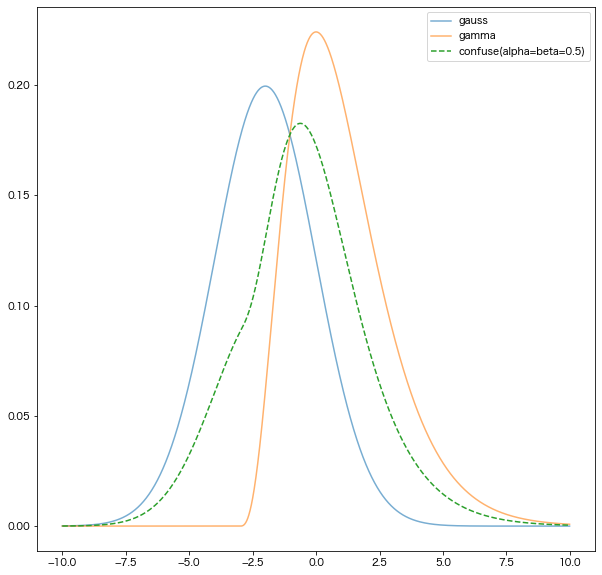

In [5]:
# データの準備
# 正規分布とガンマ分布の混合分布をきちんと分離できるかを検証

#　x軸を作成
x_axis = np.arange(-10,10,0.01)

# 正規分布の確率密度関数を作成
norm_data = norm.pdf(x_axis, -2, 2)

# ガンマ分布の確率密度関数作成
gamma_data = gamma.pdf(x_axis,4,-3,1)

# 混合分布の作成
# 混合分布を作成する関数を作成
def confuse_distribution(data1,data2):
    '''
    data1とdata2の混合分布を作成 (各分布の影響度合いはランダムに決定)
    '''
    confuse_list = []
    for i in range(2500):
        
        # 
        
        # 影響度合いをランダムで作成
        alpha = np.random.rand()
        beta = np.random.rand()
        
        '''
        # 確率的に、alpha, betaどちらかを0にする
        if np.random.rand() < 0.03:
            alpha = 0
        elif np.random.rand() > 0.99:
            alpha = 1
        
        if np.random.rand() < 0.03:
            beta = 0
        elif np.random.rand() > 0.98:
            beta = 1
        '''
        
        # 混合分布の作成 (単純な線形結合だとNMFで分割できるので、強めなノイズを入れる)
        confuse_temp = alpha*data1 + beta*data2 + norm.pdf(x_axis,-10,10)
        
 
        confuse_list.append(confuse_temp)
    
    # ndarray化
    confuse_list = np.array(confuse_list)
    
    return confuse_list

# 混合分布を作成
confuse_data = confuse_distribution(norm_data, gamma_data)
print(f'Number of data : {confuse_data.shape}')
print(f'サンプルサイズは{confuse_data.shape[0]}, 変数は{confuse_data.shape[1]}')

# 両分布の可視化
plt.figure(figsize=(10,10))
plt.plot(x_axis, norm_data,label='gauss',alpha=0.6)
plt.plot(x_axis, gamma_data,label='gamma',alpha=0.6)
plt.plot(x_axis, 0.5*norm_data+0.5*gamma_data,label='confuse(alpha=beta=0.5)',linestyle='dashed')
# plt.plot(x_axis, (0.2*norm_data+0.8*gamma_data),label='confuse(alpha=0.2, beta=0.8)',linestyle='dashed')
plt.legend()
plt.show()


In [14]:
# MCR-ALSの準備

def MCRALS(D, n_component, max_iter):
    '''
    - 引数
    D : 測定データ(n×λ)(ndarray or pd.DataFrame)
    n_component : 分割する成分数(int)
    max_iter：繰り返す数(int)
    
    - 返り値
    測定データの濃度 (C)および純成分スペクトル(S)
    '''
    
    # 定数の定義
    N = D.shape[0]
    lambda_D = D.shape[1]
    k = n_component
    MAX_ITER = max_iter
    
    # 初期濃度の設定
    C_initial = np.random.rand(N,k)
    
    # ALSの実行
    C = C_initial
    for i in range(MAX_ITER):
        
        # Sについて解く
        S_T = (np.linalg.inv(C.T@C)) @ C.T @ D
        
        # Sの負値を0に変換し、転置してSに戻す
        S_T = np.where(S_T<0, 0, S_T)
        S = S_T.T
        
        # Cについて解く
        C_T = (np.linalg.inv(S.T@S)) @ S.T @ D.T
        
        # Cの負値を0に変換し、転置してCに戻す
        C_T = np.where(C_T<0, 0, C_T)
        C = C_T.T
        
    return C, S
    

In [15]:
%%time
# 実行

C_temp, S_temp = MCRALS(
    D = confuse_data,
    n_component = 2,
    max_iter = 200
)

CPU times: user 13.2 s, sys: 406 ms, total: 13.6 s
Wall time: 1.62 s


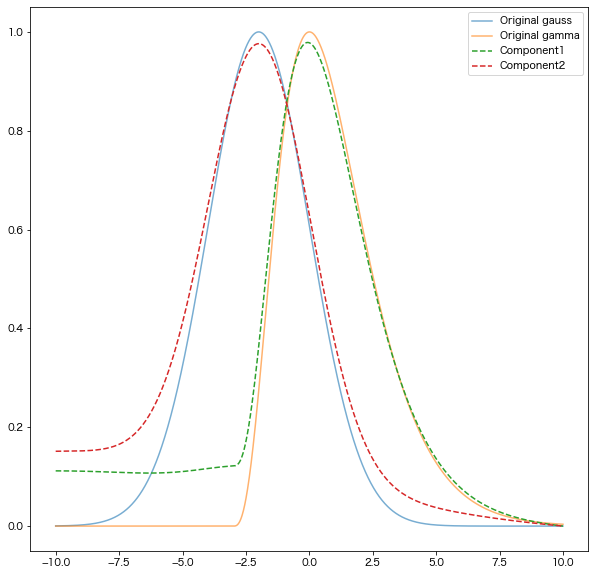

Component1とGamma分布の類似度 ：0.9777
Component2とGauss分布の類似度：0.9803


In [16]:
# 純成分を可視化

##### 諸関数の準備 #####
def max_min(D):
    '''
    min-max処理
    '''
    return ((D - np.min(D)) / np.max(D))

def cosine(data1, data2):
    '''
    ピュア分布と分割後の分布のコサイン類似度を算出
    '''
    return data1 @ data2 / (np.sqrt((data1**2).sum())*np.sqrt((data2**2).sum()))

##########

# 純成分の可視化
plt.figure(figsize=(10,10))
plt.plot(x_axis, max_min(norm_data),label='Original gauss',alpha=0.6)
plt.plot(x_axis, max_min(gamma_data),label='Original gamma',alpha=0.6)
plt.plot(x_axis, max_min(S_temp[:,0]) ,label='Component1',linestyle='dashed')
plt.plot(x_axis, max_min(S_temp[:,1]),label='Component2',linestyle='dashed')
plt.legend()
plt.show()

print(f'Component1とGamma分布の類似度 ：{cosine(S_temp[:,0],gamma_data):.4f}')
print(f'Component2とGauss分布の類似度：{cosine(S_temp[:,1],norm_data):.4f}')